# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [3]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [4]:
# from sklearn.metrics import accuracy_score,classification_report
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import svm

mnist = fetch_openml('mnist_784')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

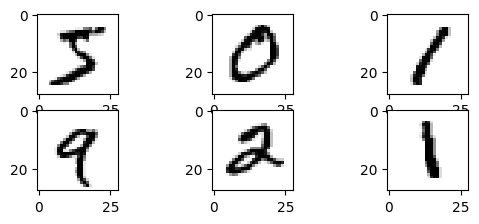

In [58]:
print(mnist.DESCR)
mnist.target.shape

'''
image= mnist.data.to_numpy()
plt.subplot(431)
plt.imshow((image[0].reshape(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.subplot(432)
plt.imshow(image[1].reshape(28,28), cmap=plt.cm.gray_r, interpolation= 'nearest')
plt.subplot(433)
plt.imshow(image[3].reshape(28,28), cmap=plt.cm.gray_r, interpolation= 'nearest')
plt.subplot(434)
plt.imshow(image[4].reshape(28,28), cmap=plt.cm.gray_r, interpolation= 'nearest')
plt.subplot(435)
plt.imshow(image[5].reshape(28,28), cmap=plt.cm.gray_r, interpolation= 'nearest')
plt.subplot(436)
plt.imshow(image[6].reshape(28,28), cmap=plt.cm.gray_r, interpolation= 'nearest')
'''

index_number= np.random.permutation(70000)
x1,y1=mnist.data.loc[index_number],mnist.target.loc[index_number]
x1.reset_index(drop=True,inplace=True)
y1.reset_index(drop=True,inplace=True)
x_train , x_test = x1[:55000], x1[55000:]
y_train , y_test = y1[:55000], y1[55000:]



In [ ]:
mnist.data

In [8]:
mnist.target.shape

(70000,)

In [9]:
x_train_array = x_train.to_numpy()
x_train_array = x_train_array/255
# The original pixel values range from 0 to 255. So, we divided them by 255 to get them into the range of 0.0 to 1.0.
# https://www.google.com/search?client=opera&q=how+mnist+dataset+is+normalized&sourceid=opera&ie=UTF-8&oe=UTF-8
type(x_train_array[0])

numpy.ndarray

In [ ]:
y_train
y_train_array = y_train.to_numpy(dtype=int)
def normalize_to_vector(a:int):
    arr = np.zeros(10)
    arr[a] +=1
    return arr

y_train_array = np.array([normalize_to_vector(number) for number in y_train_array])
print(y_train_array)

In [272]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.rand(self.input_size, self.output_size) - 0.5  # [[w1,w1,w1,w1,...],[w2,w2...]]
        self.biases = np.random.rand(1, self.output_size)


    def forward(self, x_input:np.ndarray)->np.ndarray:
        print("FullyConnected(Layer) - forward -> input: ", x_input.shape)
        self.input = x_input.reshape(1,self.input_size)
        print(self.input)
        print("FullyConnected(Layer) - forward -> input: ", self.input.shape)
        self.output = np.array([np.dot(self.input, neuron_weights) + self.biases[0][index] for index, neuron_weights in enumerate(self.weights.T)])
        print("FullyConnected(Layer) - forward -> output: ", self.output.shape)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:

        # later try to delete...
        # in the future it should be that shape and it could be irrelevant
        # {
        output_error_derivative = output_error_derivative.reshape(1, self.output_size)
        # }

        print("FullyConnected(Layer) - backward -> output_derivative: ", output_error_derivative.shape)

        # output_error_derivative = dE/dz
        # input_error_derivative: dE/dx = dE/dz * dz/dx
        input_error_derivative = np.dot(output_error_derivative, self.weights.T)
        # weight_error_derivative: dE/dw = dE/dz * dz/dw
        weight_error_derivative =  np.dot(self.input.T, output_error_derivative)
        # bias_error_derivative: dE/db = dE/db = dE/dz * dz/db (=1) = dE/dz
        bias_error_derivative = output_error_derivative

        # gradient descent
        self.weights -= weight_error_derivative * self.learning_rate
        self.biases -= bias_error_derivative * self.learning_rate

        print("FullyConnected(Layer) - backward -> input_derivative: ", input_error_derivative.shape)
        return input_error_derivative

class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x:np.ndarray)->np.ndarray:
        return np.tanh(x)

    def backward(self, output_error_derivative)->np.ndarray:
        pass # return 1 - np.tanh(x)**2 -> tanh_derivative(x)

class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""

        pass

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        pass

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        pass

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        output = x
        for layer in self.layers:
            print(len(output))
            output = layer.forward(output)
        return output

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""

        # loss_function =
        self.compile(Loss())



        pass

In [273]:
#n = Network([FullyConnected(28*28, 10), Tanh()], 0.01)
#n.fit(x_train_array, y_train_array)
#n.__call__(x_train_array[0])


fc = FullyConnected(28**2, 10)
fc.forward(x_train_array[0])
fc.backward(y_train_array[0])
_ = ""




FullyConnected(Layer) - forward -> input:  (784,)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.  

<class 'numpy.ndarray'>


# Eksperymenty

# Wnioski